# Mask Generation

This notebook is used to try and play around with the ground truth dense segmentation mask generation.

Each bee below shows:
- Raw image crop
- Dense segmentation mask:
  - Head = green
  - Tail = blue
  - Background = black
- Overlay: mask transparently drawn over the image

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import random

# Print the OpenCV version
print("OpenCV version:", cv2.__version__)

OpenCV version: 4.11.0


In [7]:
def create_bee_segmentation_mask(cropped_img, annotation, ellipse_axes):
    """
    Create a dense segmentation mask for a cropped bee image.

    Args:
        cropped_img (np.array): cropped bee RGB image (H, W, 3)
        annotation (dict): dict with keys 'angle' (radians)
        ellipse_axes (tuple): (major_axis, minor_axis) length for ellipse

    Returns:
        mask (np.array): 2D array (H, W) with labels:
            0 = background
            1 = head half ellipse
            2 = tail half ellipse
    """
    h, w = cropped_img.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)

    # Ellipse center in mask/image coords: center of cropped image
    ellipse_center = (w // 2, h // 2)

    # Convert angle to degrees + 90 offset for OpenCV ellipse drawing
    angle_rad = annotation["angle"]
    angle_deg = math.degrees(angle_rad + math.pi/2)

    # Determine head and tail angle ranges (with +90 offset)
    head_angles = (90, 270)
    tail_angles = (270, 450)

    # Draw head half ellipse with label 1
    cv2.ellipse(
        mask,
        ellipse_center,
        ellipse_axes,
        angle_deg,
        head_angles[0],
        head_angles[1],
        color=1,
        thickness=-1
    )

    # Draw tail half ellipse with label 2
    cv2.ellipse(
        mask,
        ellipse_center,
        ellipse_axes,
        angle_deg,
        tail_angles[0],
        tail_angles[1],
        color=2,
        thickness=-1
    )

    return mask

In [8]:
image_path = 'frame_30fps_001515.png'
annotation_path = 'frame_30fps_001515.txt'
ellipse_axes = (55, 20)
crop_size = 160

# === LOAD IMAGE & ANNOTATIONS ===
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

with open(annotation_path, 'r') as f:
    lines = f.readlines()

# === PARSE BEE ANNOTATIONS ===
bee_annotations = []
for line in lines:
    parts = line.strip().split()
    if len(parts) != 6:
        continue
    offset_x, offset_y, bee_class, pos_x, pos_y, angle = map(float, parts)
    if int(bee_class) == 1:
        bee_annotations.append({
            "offset_x": offset_x,
            "offset_y": offset_y,
            "class": int(bee_class),
            "position_x": pos_x,
            "position_y": pos_y,
            "angle": angle
        })

## Misaligned Annotation Examples

Some of the annotations in the dataset are visibly misaligned -- for example, the head/tail segments may not perfectly overlap with the bee's actual position. We've included a few examples below to highlight this.

We're aware of these cases, but from what we've seen so far, they appear to be outliers rather than a systematic issue. Since we didn’t want to alter the original dataset directly (and thus avoid needing to redistribute a full modified version), we’re keeping the annotations as-is and applying our processing on top. 

If needed, adjustments can easily be applied through the existing modification script. For now, our assumption is that these misalignments are limited enough to not significantly impact downstream training or analysis, but we’d definitely be open to revisiting this if you advise otherwise.


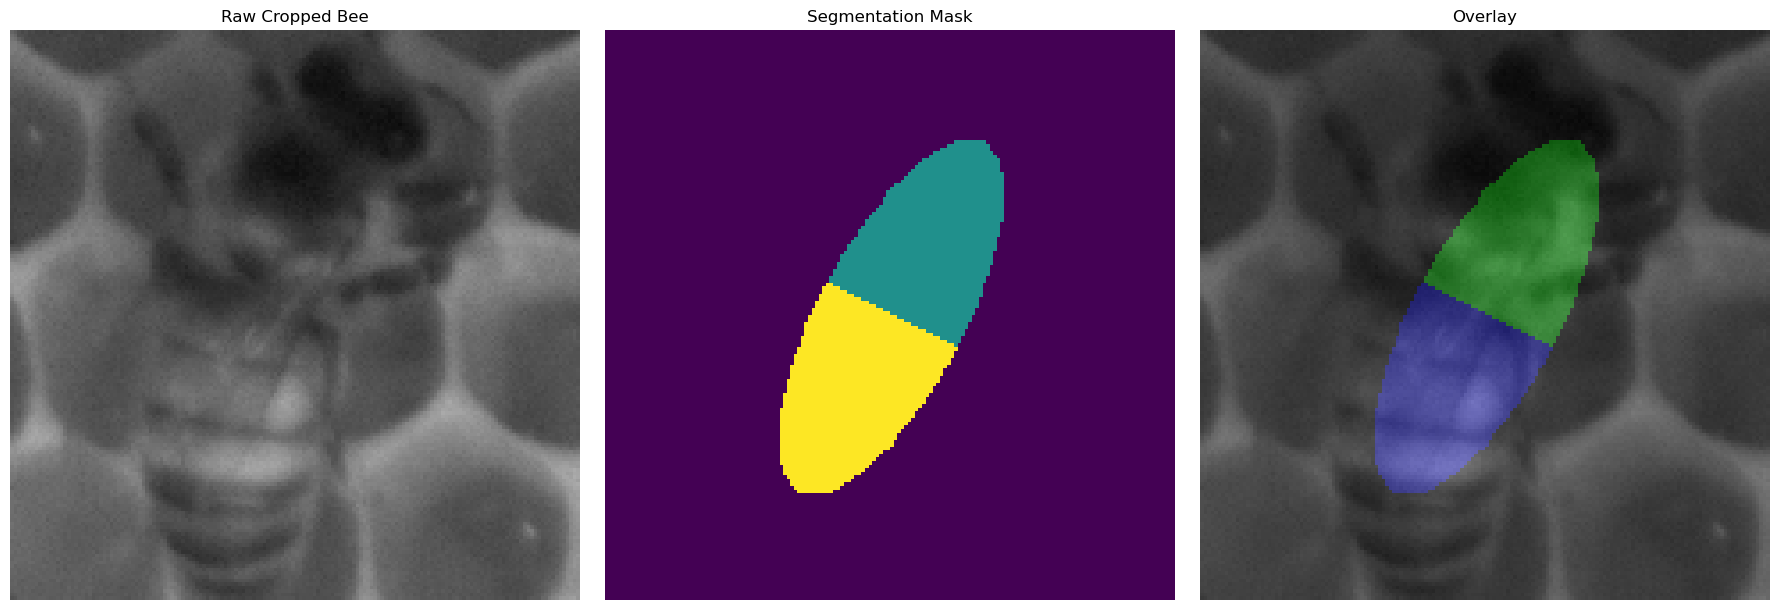

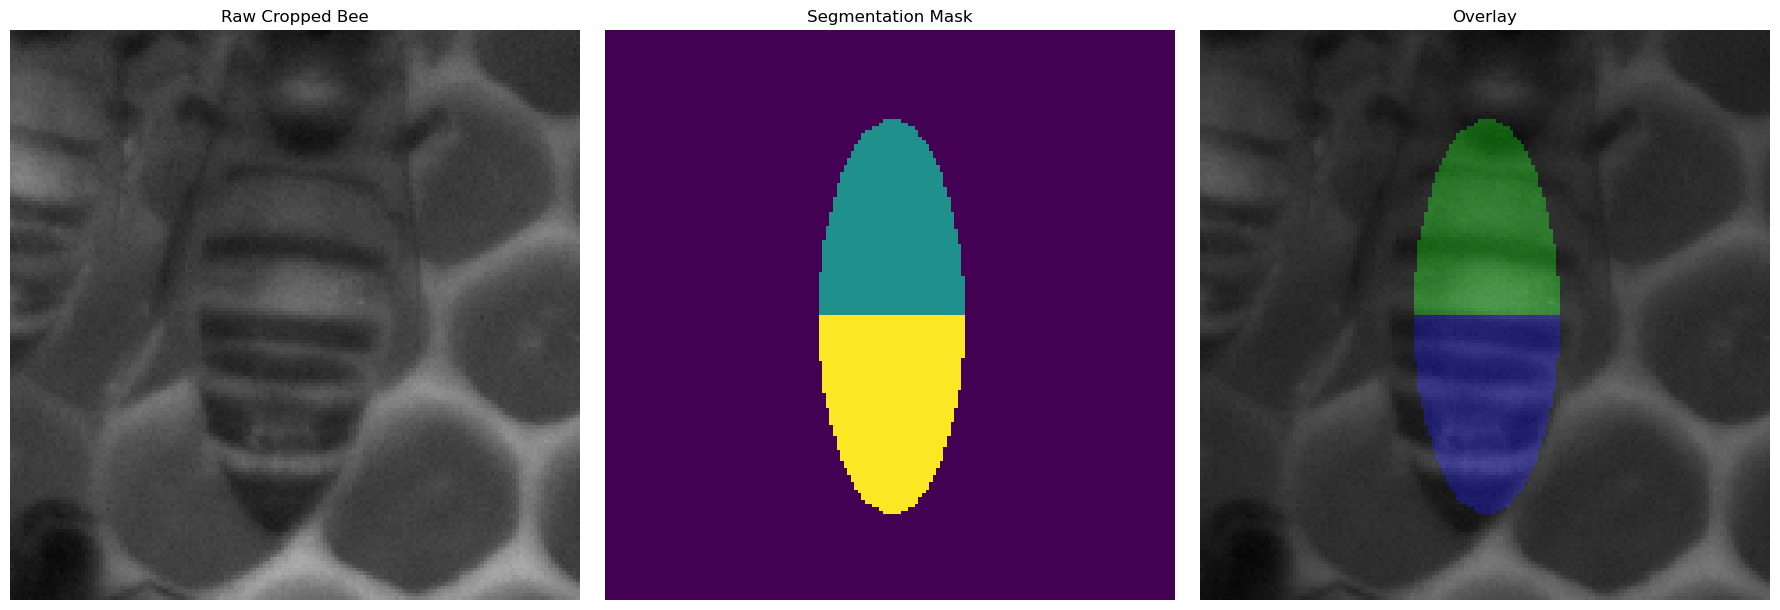

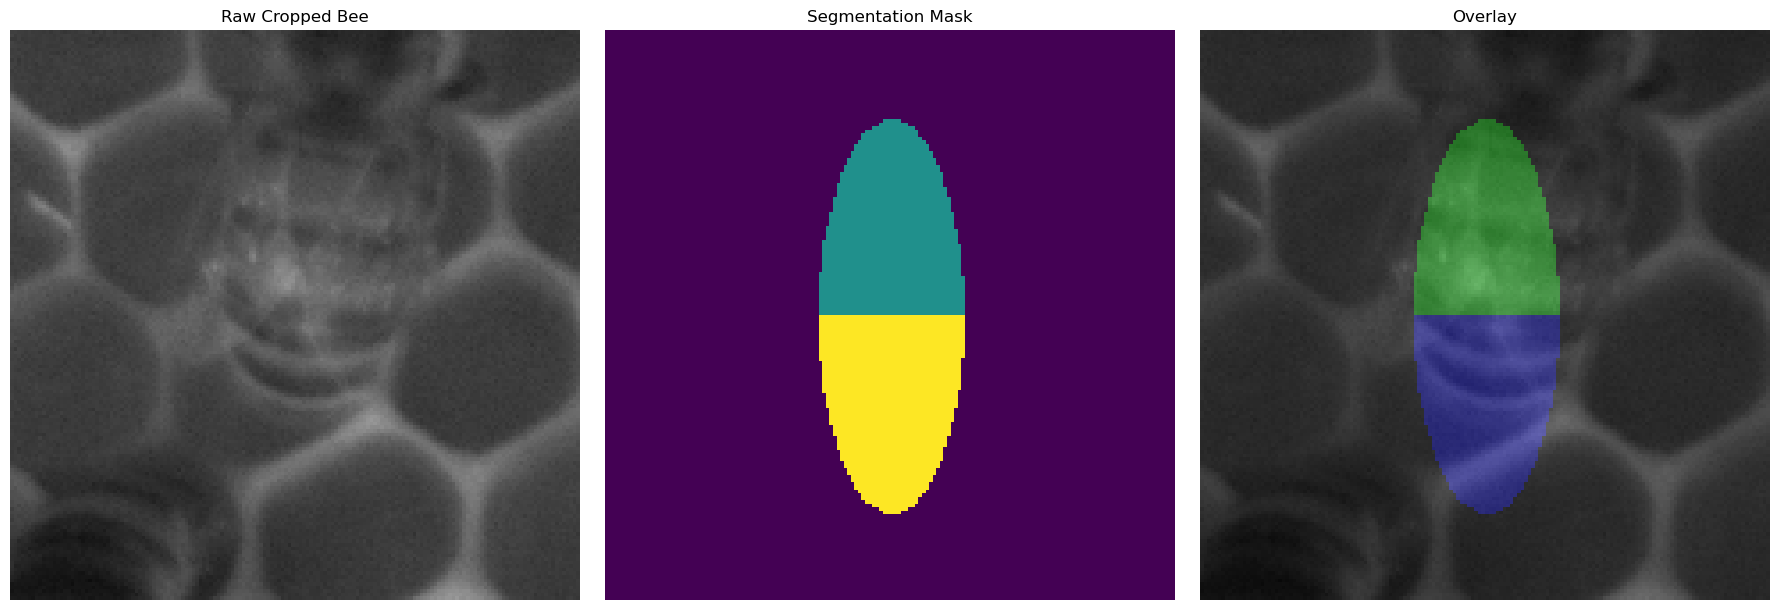

In [9]:
# === Misaligned Annotations ===
missaligned = [bee_annotations[0], bee_annotations[3], bee_annotations[4]]
for annotation in missaligned:
    cx = int(annotation["position_x"] + annotation["offset_x"])
    cy = int(annotation["position_y"] + annotation["offset_y"])
    half_crop = crop_size // 2
    x1, y1 = max(cx - half_crop, 0), max(cy - half_crop, 0)
    x2, y2 = min(cx + half_crop, image.shape[1]), min(cy + half_crop, image.shape[0])

    cropped_bee = image_rgb[y1:y2, x1:x2].copy()
    mask = create_bee_segmentation_mask(cropped_bee, annotation, ellipse_axes)

    # Create color mask
    color_map = {0: (0, 0, 0), 1: (0, 255, 0), 2: (0, 0, 255)}
    color_mask = np.zeros_like(cropped_bee)
    for label, color in color_map.items():
        color_mask[mask == label] = color

    overlay = cv2.addWeighted(cropped_bee, 0.7, color_mask, 0.3, 0)

    # Plot results
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    axs[0].imshow(cropped_bee)
    axs[0].set_title("Raw Cropped Bee")
    axs[0].axis("off")

    axs[1].imshow(mask)
    axs[1].set_title("Segmentation Mask")
    axs[1].axis("off")

    axs[2].imshow(overlay)
    axs[2].set_title("Overlay")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()

## Random Samples

These examples are randomly sampled from the current annotation frame.

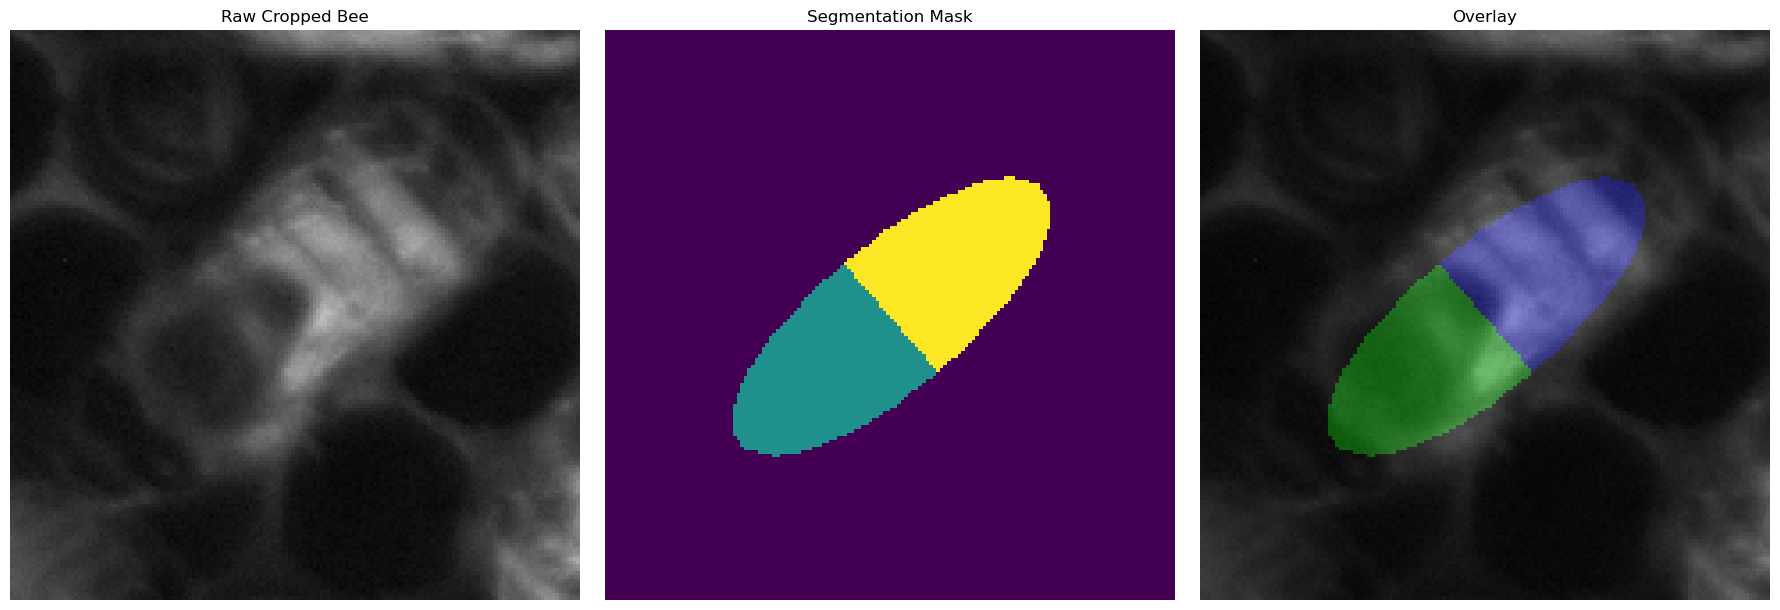

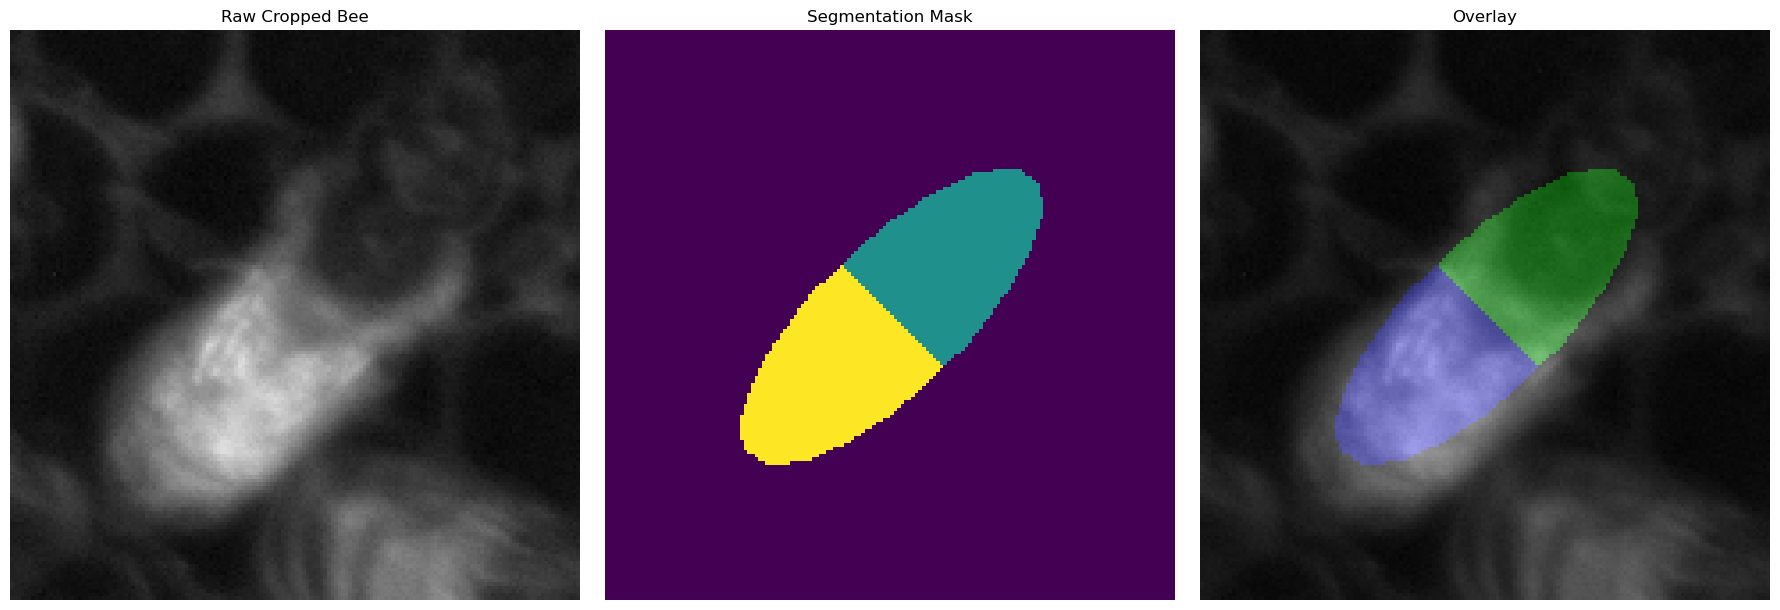

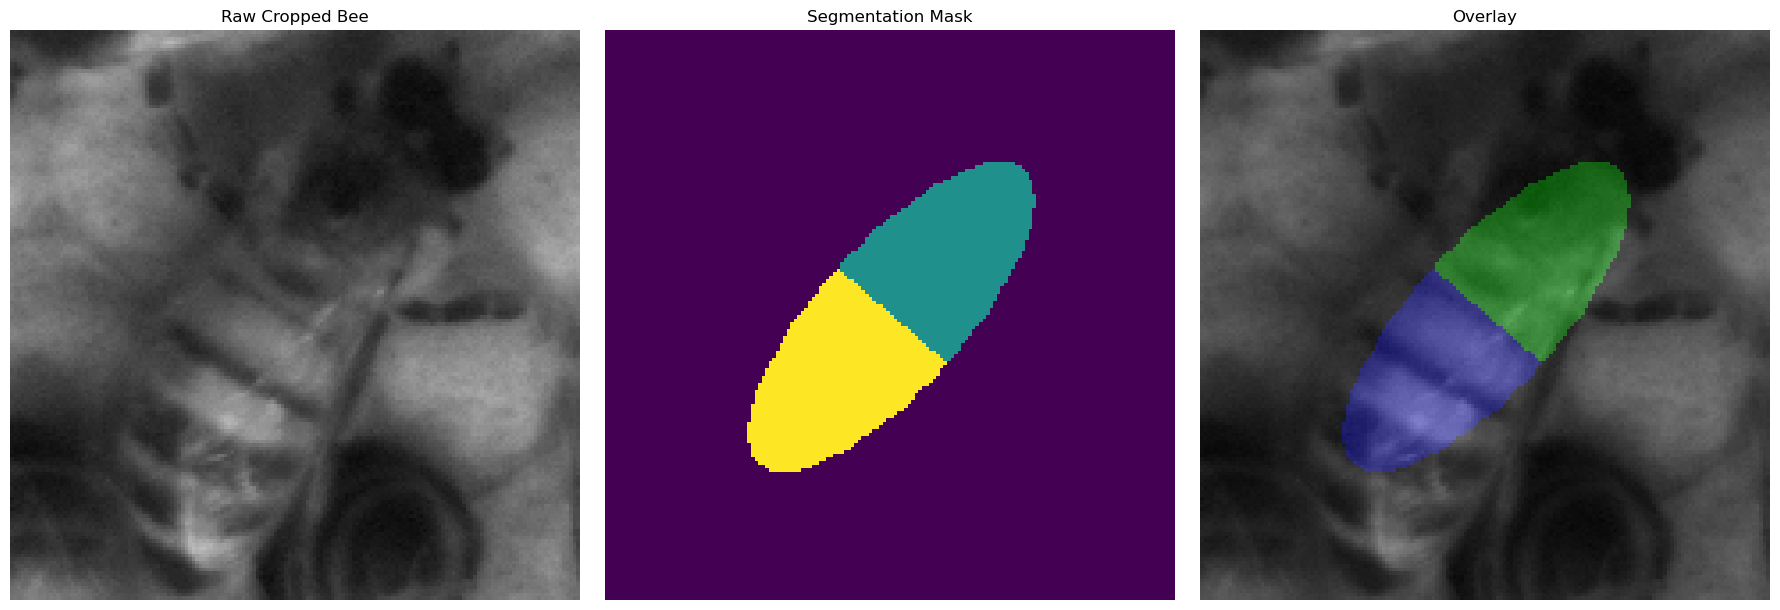

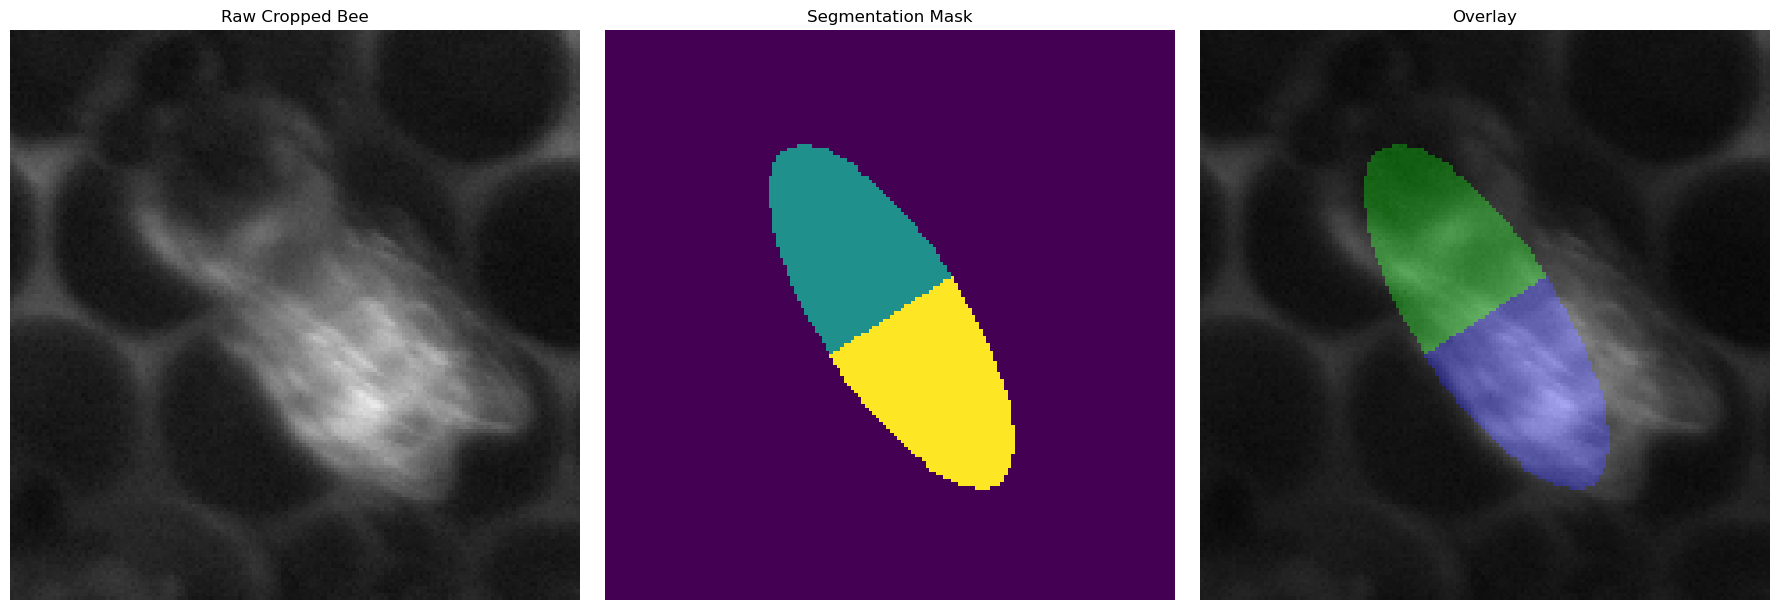

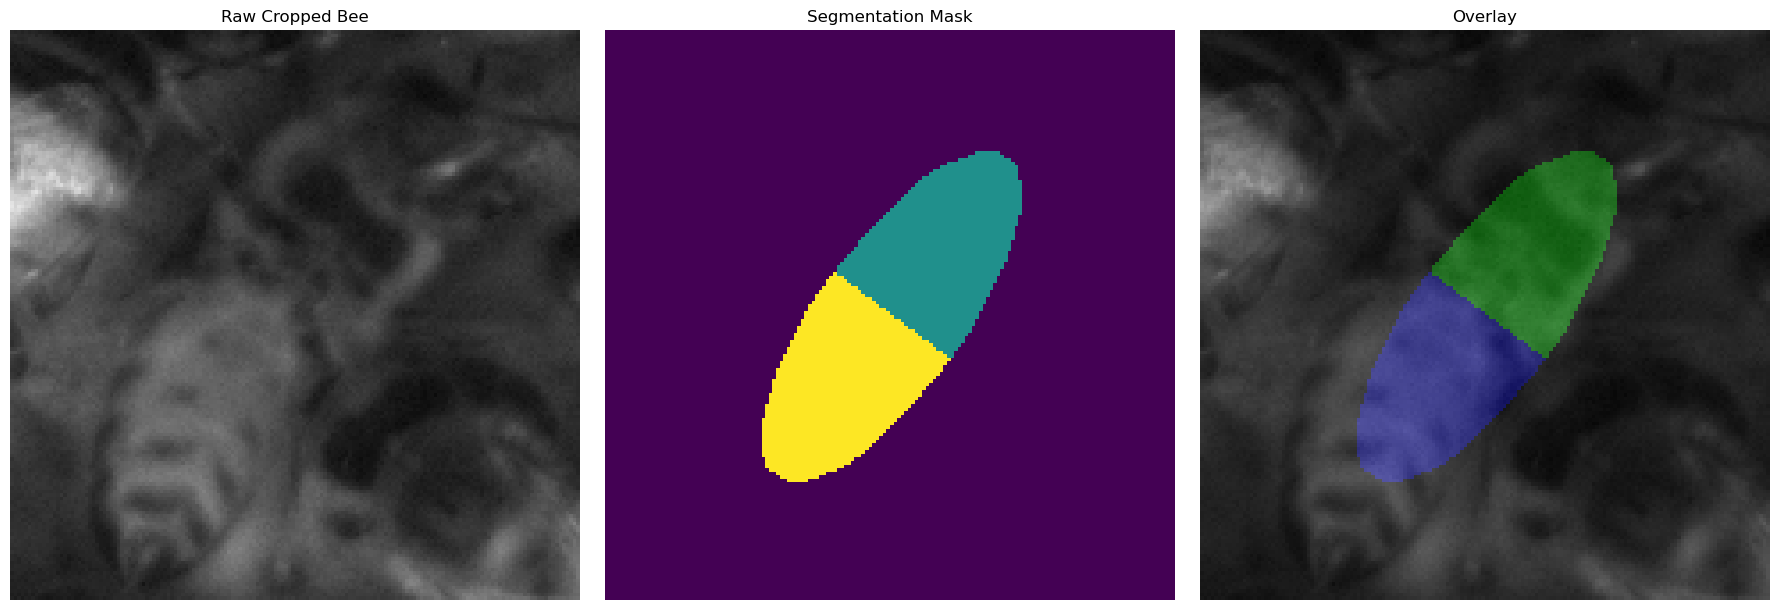

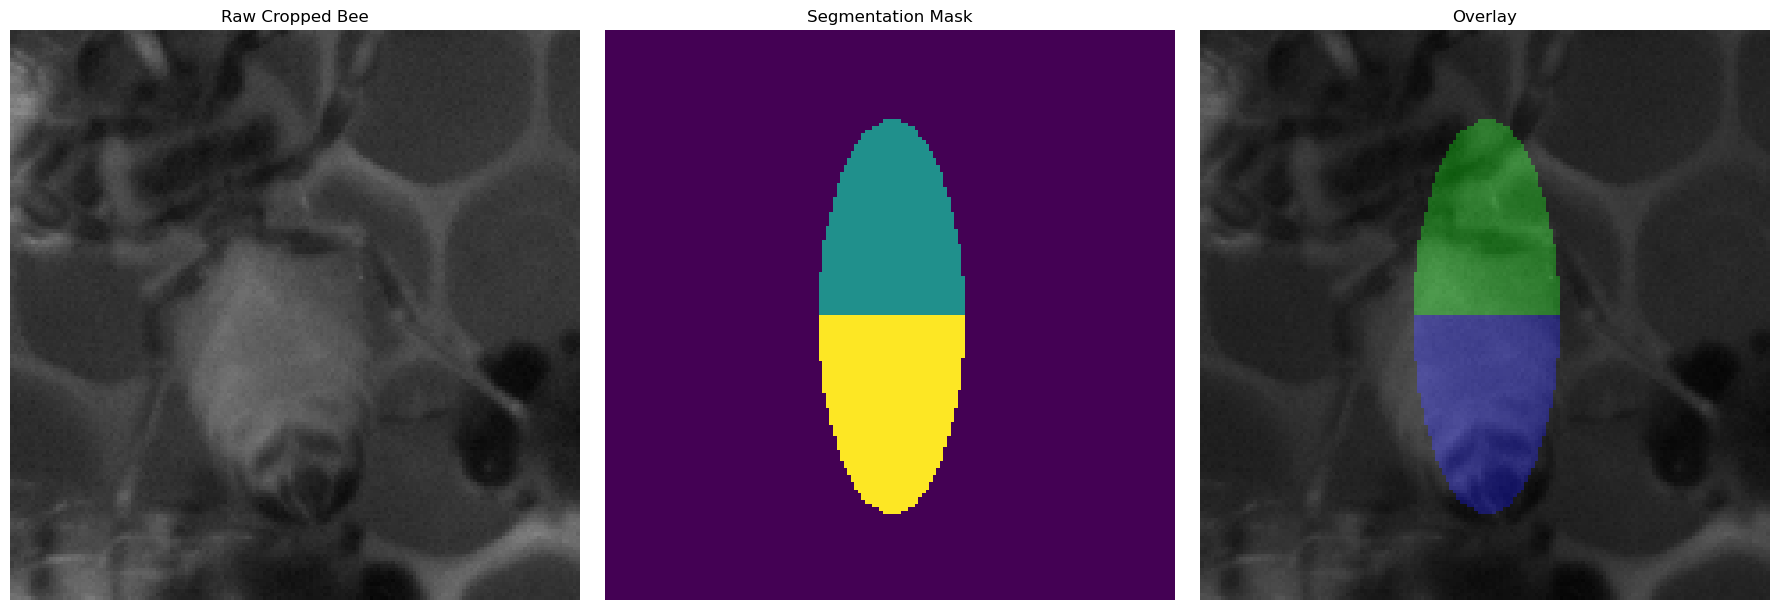

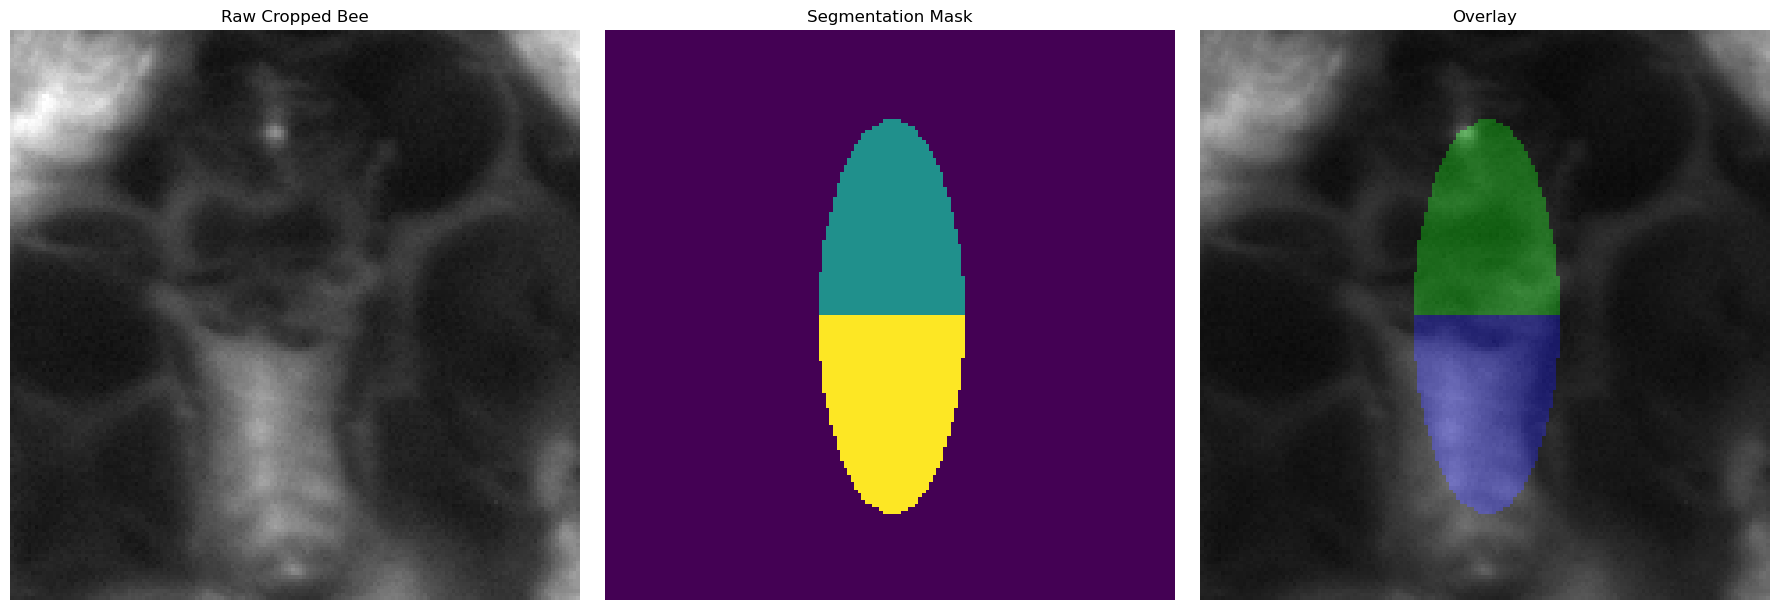

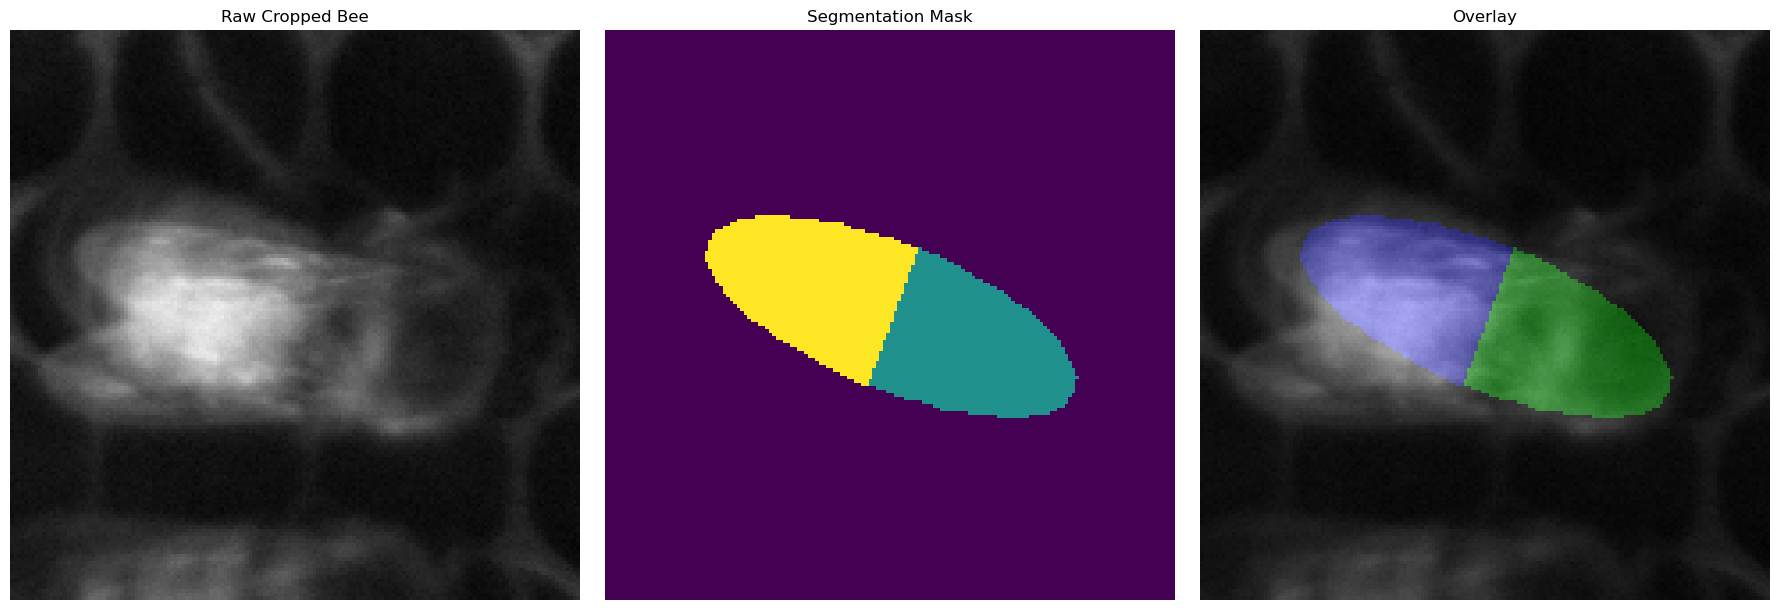

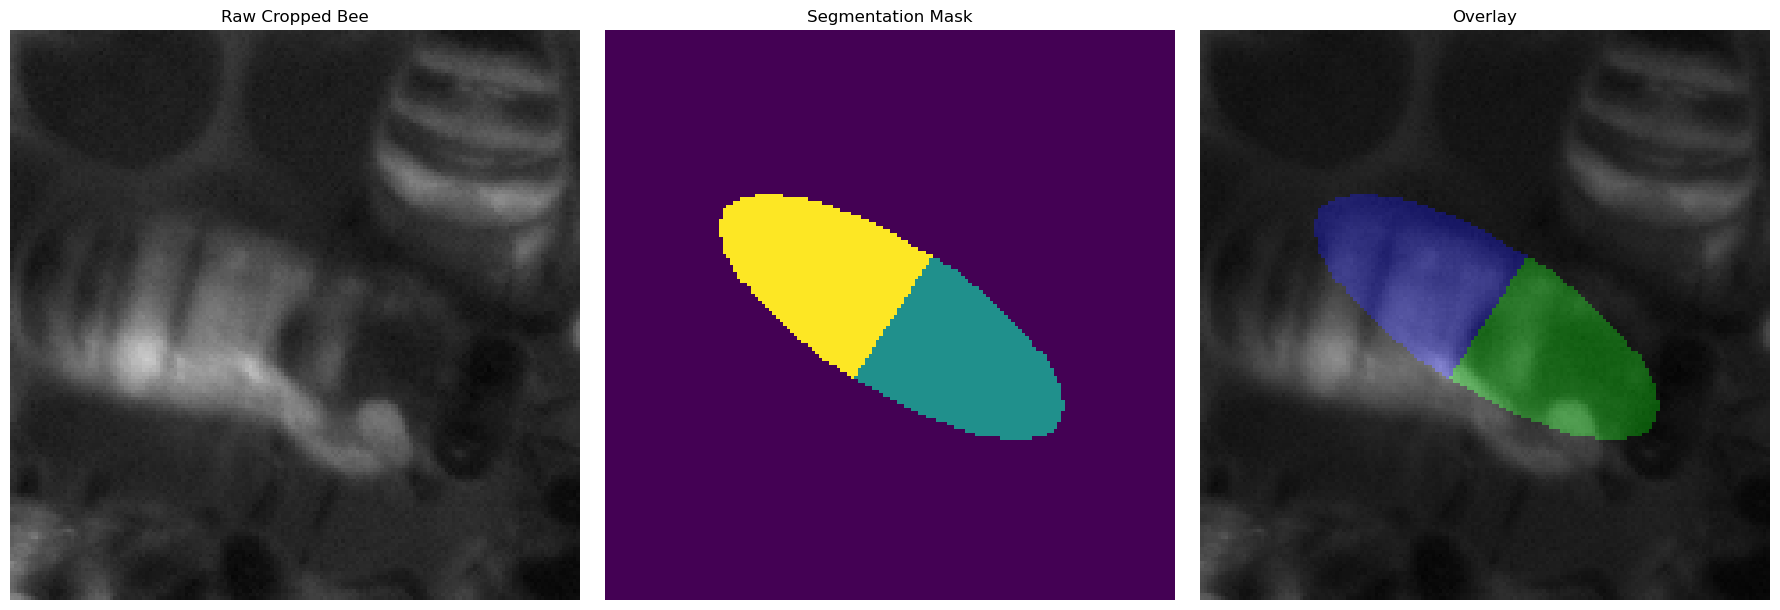

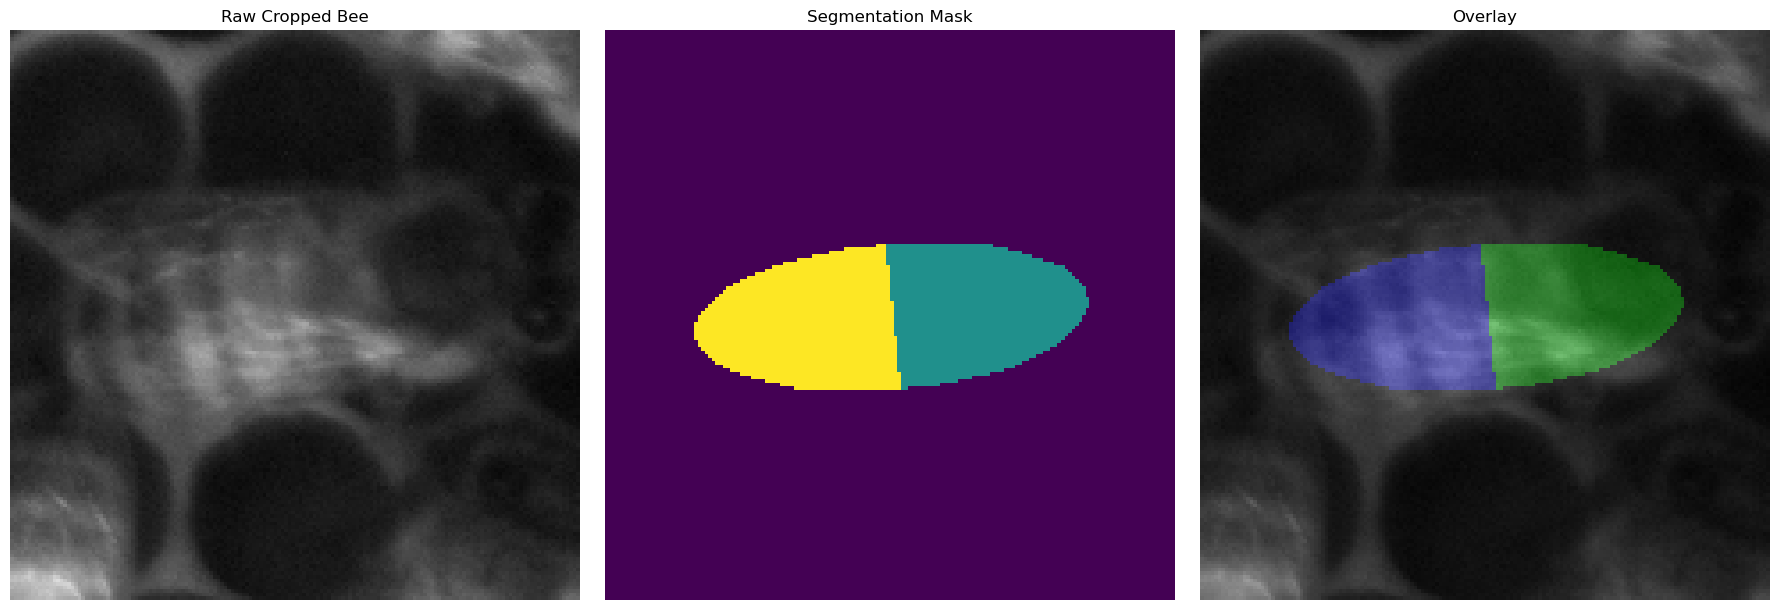

In [10]:
# === SAMPLE AND DISPLAY RANDOM BEES ===
num_bees_to_display = 10

for annotation in random.sample(bee_annotations, min(num_bees_to_display, len(bee_annotations))):
    cx = int(annotation["position_x"] + annotation["offset_x"])
    cy = int(annotation["position_y"] + annotation["offset_y"])
    half_crop = crop_size // 2
    x1, y1 = max(cx - half_crop, 0), max(cy - half_crop, 0)
    x2, y2 = min(cx + half_crop, image.shape[1]), min(cy + half_crop, image.shape[0])

    cropped_bee = image_rgb[y1:y2, x1:x2].copy()
    mask = create_bee_segmentation_mask(cropped_bee, annotation, ellipse_axes)

    # Create color mask
    color_map = {0: (0, 0, 0), 1: (0, 255, 0), 2: (0, 0, 255)}
    color_mask = np.zeros_like(cropped_bee)
    for label, color in color_map.items():
        color_mask[mask == label] = color

    overlay = cv2.addWeighted(cropped_bee, 0.7, color_mask, 0.3, 0)

    # Plot results
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    axs[0].imshow(cropped_bee)
    axs[0].set_title("Raw Cropped Bee")
    axs[0].axis("off")

    axs[1].imshow(mask)
    axs[1].set_title("Segmentation Mask")
    axs[1].axis("off")

    axs[2].imshow(overlay)
    axs[2].set_title("Overlay")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()